# Low-power heart sound segmentation model on FPGA
## Basic functonality. Driver.

In [1]:
from pynq import Overlay, DefaultIP
import numpy as np
from tqdm import tqdm

In [2]:
class SegmenterDriver(DefaultIP):
    bindto = ['xilinx.com:hls:Segmenter:1.0']
    
    from fxpmath import Fxp
    from tqdm import tqdm
    from time import perf_counter
    
    def __init__(self,description):
        super().__init__(description=description)
        
        self.X_ADDR = description['registers']['Memory_x_V']['address_offset']
        self.Y_ADDR = description['registers']['Memory_y_V']['address_offset']
        
        self.N = None # Number of input time points
        self.N_FEATURES = None # Number of input features
        self.N_CLASSES = None # Number of output classes
        
        self.W = None # Number of total bits of the fixed-point datatype
        self.I = None # Number of integer bits of the fixed-point datatype
        
        self.APFIXED = None # Type to use as template
        
        self.configured = False
    
    def configure(self, N, N_FEATURES, N_CLASSES, W, I):
        """
        Set the neural network input and output
        shape and choose fixed-point datatype number
        of bits.

        Args:
            N (int): Number of input time points
            N_FEATURES (int): Number of input features
            N_CLASSES (int): Number of output classes
            W (int): Number of total bits of the fixed-point datatype
            I (int): Number of integer bits of the fixed-point datatype
        """
        
        self.N = N
        self.N_FEATURES = N_FEATURES
        self.N_CLASSES = N_CLASSES

        self.W = W
        self.I = I

        self.APFIXED = self.Fxp(None, signed=True, n_word=self.W, n_frac=self.W-self.I)

        self.configured = True
    
    def _write_array(self, offset, data):
        """
        Write an array of data to the memory
        mapped to the IP.

        Args:
            offset (int): Offset in the memory to write the data.
            data (numpy.ndarray): Data to write.
        """

        assert self.W == 16, "Only 16-bit fixed-point datatype is supported"

        # Load data as as APFIXED type
        data_fixed = self.Fxp(data).like(self.APFIXED)

        # Flatten data
        data_fixed = data_fixed.flatten()

        # Get the integer asociated integer values
        data_fixed = data_fixed.uraw()

        # Join each pair of integer values into a single 32-bit value
        for i in range(len(data_fixed)//2):
            self.write(offset + i*4, int((data_fixed[2*i+1] << 16) + data_fixed[2*i]))

        # If the number of elements is odd, write the last element
        if len(data_fixed) % 2 != 0:
            self.write(offset + len(data_fixed)//2*4, int(data_fixed[-1]))
    
    def _read_array(self, offset, shape):
        """
        Read an array of data from the memory
        mapped to the IP.

        Args:
            offset (int): Offset in the memory to read the data.
            shape (tuple): Shape of the array to read.
        """

        assert self.W == 16, "Only 16-bit fixed-point datatype is supported"

        data = np.zeros(shape, dtype=np.float32).flatten()

        for i in range(len(data)//2):
            uint32 = self.read(offset + i*4)
            data[2*i] = uint32 & 0xFFFF
            data[2*i+1] = uint32 >> 16

        data_fixed = self.Fxp(None).like(self.APFIXED)
        data_fixed.set_val(data, raw=True)

        return data_fixed.get_val().reshape(shape)
    
    def predict(self, x):
        
        assert self.configured, "Segmenter not configured. Please call configure() method first."
        
        assert x.ndim == 3
        assert x.shape[1] == self.N
        assert x.shape[2] == self.N_FEATURES

        y = np.zeros((x.shape[0], self.N, self.N_CLASSES), dtype=np.float32)
        
        for i in self.tqdm(range(x.shape[0])):

            self._write_array(self.X_ADDR, x[i])
            
            self.register_map.CTRL.AP_START = 1

            while self.register_map.CTRL.AP_DONE == 0:
                pass

            y[i] = self._read_array(self.Y_ADDR, (self.N, self.N_CLASSES))
            
        return y
    
    def measure_latency(self, n_runs, n_tests=1, verbose=True):
        """
        Measure the latency running multiple times the IP.
        
        Args:
            n_runs (int): Number of times to run the IP per test.
            n_test (int, optional): Number of tests.
        """
        
        assert self.configured, "Segmenter not configured. Please call configure() method first."
        
        latencies = np.zeros(n_tests)
        
        for i in range(n_tests):
            
            t0 = self.perf_counter()

            for _ in range(n_runs):
                self.register_map.CTRL.AP_START = 1

                while self.register_map.CTRL.AP_DONE == 0:
                    pass
            t1 = self.perf_counter()
            
            latencies[i] = ((t1-t0)/n_runs)
        
            if verbose:
                print('Latency Test #{} (ms): {:.3f}'.format(i, latencies[i]*1e3))
            
        if n_tests > 1 and verbose:
            print('---------------------------')
            print('Average: {:.3f} ± {:.3f}'.format(latencies.mean()*1e3, latencies.std()*1e3))
        return latencies

In [3]:
# test.npz file provided is a small set of data due to GitHub file size limitations
with np.load('test.npz') as test_file:
    x = test_file['X']
    y = test_file['S']

In [4]:
ol = Overlay('pl_design.bit', ignore_version=True)

In [5]:
model = ol.Segmenter_0
model.configure(x.shape[1], x.shape[2], y.shape[2], 16, 8)

In [26]:
TEST_SAMPLES = 100

In [ ]:
y_fpga = model.predict(x[:TEST_SAMPLES])

In [ ]:
correct = 0
y_idx = np.argmax(y, axis=-1)[:TEST_SAMPLES]
y_fpga_idx = np.argmax(y_fpga, axis=-1)
for i in range(y_idx.shape[0]):
    for j in range(y_idx.shape[1]):
        correct += y_idx[i, j] == y_fpga_idx[i, j]
print('Accracy: {}'.format(correct/y_idx.size))

In [6]:
latencies = np.array(model.measure_latency(100, 5))

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/registers.py:369: UserWarning: Unsupported register size 512 for register Memory_x_V
  warnings.warn(
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/registers.py:369: UserWarning: Unsupported register size 512 for register Memory_y_V
  warnings.warn(


Latency Test #0 (ms): 17.960
Latency Test #1 (ms): 17.772
Latency Test #2 (ms): 17.773
Latency Test #3 (ms): 17.778
Latency Test #4 (ms): 17.771
---------------------------
Average: 17.811 ± 0.075


## Power consuption profile

In [6]:
import pyvisa
from time import perf_counter, sleep
from multiprocessing import Process, Array, Value
import matplotlib.pyplot as plt

In [ ]:
rm = pyvisa.ResourceManager('@py')
rm.list_resources()
VISA_ADDR = '' # Write here you SMU VISA address 

In [55]:
smu = rm.open_resource(VISA_ADDR)

In [8]:
def _capture_power(t, d, stop):
    """A function to launch as a subprocess to capture the power consumption.

    To get maximum performance (minimal time resolution) the function is based
    on a `while` loop checking the value of the `stop`. If the length of the
    arrays is not enough, the function will try to write data outside the array.
    This will raise a warning and the data will be lost. Therefore, choose the
    length of the arrays wisely.

    Args:
        t (SynchronizedArray): Array to store the timestamps.
        d (SynchronizedArray): Array to store measurements.
        stop (Value): Value to indicate when to stop the power measurement.
    """
    i = 0

    while not stop.value:

        t[i] = perf_counter()

        d[i] = float(smu.query('READ?'))

        i += 1

def measure_power(hls_model, max_time=10):

    SIZE = 1000

    timestamps = Array('d', [0.0]*SIZE)
    power = Array('d', [0.0]*SIZE)
    stop = Value('b', False)
    
    # Launch a subprocess to capture the power consumption while the IP
    # is running under the latency test
    p = Process(target=_capture_power, args=(timestamps, power, stop))
    sleep(2)
    p.start()
    sleep(max_time)
    t0 = perf_counter()
    
    while perf_counter() - t0 < max_time:
        hls_model.register_map.CTRL.AP_START = 1
        while hls_model.register_map.CTRL.AP_DONE == 0:
            pass

    
    stop.value = True
    p.join()

    p.close()
    
    timestamps = np.array(timestamps)
    power = np.array(power)


    # Remove the zeros from the arrays
    tmask = timestamps > 0
    timestamps = timestamps[tmask]
    power = power[tmask]

    # Get the time stamps relative to the start of the test
    timestamps = timestamps - t0
    
    power *= 12 # To get the power in Watts
    
    return timestamps, power

In [56]:
timestamps, power = measure_power(model)

In [58]:
smu.close()

In [9]:
def mean_std_without_outliers(data, m=3):
    mean = data.mean()
    std = data.std()
    mask = np.abs(data-mean) < m*std
    return data[mask].mean(), data[mask].std(), mask

In [10]:
def mean_std_power_energy(timestamps, power, latencies, return_str=False):
    power_passive_mean, power_passive_std, power_passive_mask = mean_std_without_outliers(power[timestamps < 0])
    power_active_mean, power_active_std, power_active_mask = mean_std_without_outliers(power[timestamps > 0])
    delta_p_mean = power_active_mean-power_passive_mean
    delta_p_std = np.sqrt(power_passive_std**2 + power_active_std**2)
    delta_p_str = '{:.0f}±{:.0f} mW'.format(delta_p_mean*1e3, 1e3*delta_p_std)

    energy_mean = (power_active_mean-power_passive_mean)*latencies.mean()
    energy_std = np.sqrt((power_active_mean-power_passive_mean)**2*latencies.std()**2 + latencies.mean()**2*(power_passive_std**2 + power_active_std**2))   
    energy_str = '{:.2f}±{:.2f} mJ'.format(energy_mean*1e3, energy_std*1e3)
    
    if return_str:
        return delta_p_str, energy_str
    else:
        return delta_p_mean, delta_p_std, energy_mean, energy_std

Delta P: 134±14 mW
Enegy per inference: 23.68±2.53 mJ


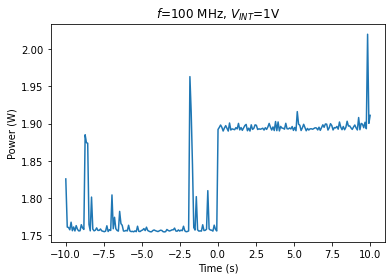

In [57]:
delta_p_str, energy_str = mean_std_power_energy(timestamps, power, latencies, True)

print('Delta P: {}\nEnegy per inference: {}'.format(delta_p_str, energy_str))

plt.plot(timestamps, power)
plt.ylabel('Power (W)')
plt.xlabel('Time (s)')

np.savez('f100_v1.npz', timestamps=timestamps, power=power)

plt.title('$f$=100 MHz, $V_{INT}$=1V')

plt.savefig('pw_profile.pdf')

plt.show()

## Power consuption over clock frequency

In [11]:
from pynq.ps import Clocks

In [59]:
smu = rm.open_resource(VISA_ADDR)

In [60]:
f_target = np.arange(10, 110, 10)
f_real = np.zeros_like(f_target)

In [61]:
delta_p_mean = np.zeros(f_target.size)
delta_p_std = np.zeros(f_target.size)
energy_mean = np.zeros(f_target.size)
energy_std = np.zeros(f_target.size)

latency_mean = np.zeros(f_target.size)
latency_std = np.zeros(f_target.size)

for i in tqdm(range(f_target.size)):
    Clocks.fclk0_mhz = f_target[i]
    f_real[i] = Clocks.fclk0_mhz
    
    latencies = model.measure_latency(10, 5, False)
    timestamps, power = measure_power(model)
    
    delta_p_mean[i], delta_p_std[i], energy_mean[i], energy_std[i] = mean_std_power_energy(timestamps, power, latencies)
    
    latency_mean[i] = latencies.mean()
    latency_std[i] = latencies.std()

np.savez('f_dependency_vint1.npz', f=f_real, delta_p_mean=delta_p_mean, delta_p_std=delta_p_std, energy_mean=energy_mean, energy_std=energy_std, latency_mean=latency_mean, latency_std=latency_std)

 20%|██        | 2/10 [00:57<03:47, 28.48s/it]/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 30.30303MHz.
  warnings.warn(
 50%|█████     | 5/10 [02:11<02:06, 25.28s/it]/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 58.82353MHz.
  warnings.warn(
 60%|██████    | 6/10 [02:35<01:39, 24.76s/it]/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 71.42857MHz.
  warnings.warn(
 70%|███████   | 7/10 [02:58<01:13, 24.34s/it]/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 83.33333MHz.
  warnings.warn(
 80%|████████  | 8/10 [03:21<00:48, 24.02s/it]/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest 

In [62]:
smu.close()

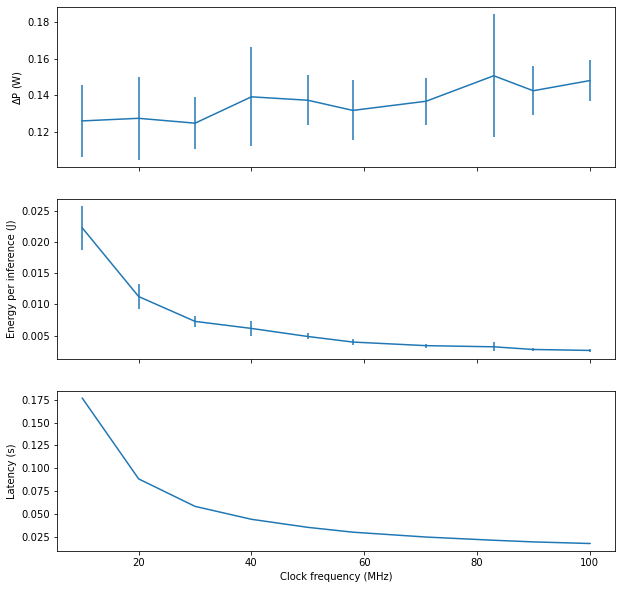

In [63]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(10,10))

axs[0].errorbar(f_real, delta_p_mean, yerr=delta_p_std)
axs[0].set_ylabel('$\Delta$P (W)')

axs[1].errorbar(f_real, energy_mean, yerr=energy_std)
axs[1].set_ylabel('Energy per inference (J)')

axs[2].errorbar(f_real, latency_mean, yerr=latency_std)
axs[2].set_ylabel('Latency (s)')
axs[2].set_xlabel('Clock frequency (MHz)')

plt.savefig('f_dependency_vint1.pdf')


plt.show()

In [66]:
Clocks.fclk_0 = 100 # Reset clock to default

## Power consumption over $V_{INT}$

In [12]:
class PMIC:
    def __init__(self, axiic, addr):
        
        self.axiic = axiic
        self.addr = addr
        
        self._write(0x10, [0b00100000]) # Enable the VREF Command
        
        self._write(0x00, [0x00]) # Access page 0, dedicated to SW1, source of Vint
        
    def _read(self, reg_addr, length):
        """
        Reads a register with multiple bytes in a PMBus device.

        Args:
            reg_addr (int): Addres of the register to read.
            length (int): Number of bytes to read from device at register.
        """
        
        assert self.addr != None, "Set the device address first! Use addr property."
        
        buffer = bytes(32) # Max length 32


        self.axiic.send(self.addr, [reg_addr], 1, 1) # Send a
        self.axiic.receive(self.addr, buffer, length, 0)

        return buffer[:length]

    def _write(self, reg_addr, data):
        """
        Writes a register with multiple bytes in a PMBus device.

        Args:
            reg_addr (int): Address of the register to write.
            data (list): List of data to be writen.
        """
        
        assert self.addr != None, "Set the device address first! Use addr property."

        return self.axiic.send(self.addr, [reg_addr] + data, len(data)+1, 0)
    
    def set_vint(self, voltage):
        """
        Sets the Vint by changing the desired voltage
        in SW1 using the VREF_COMMAND.
        
        Args:
            voltage (float) Value of the voltage in Vint to be set.
        """
        
        # Compute the desired voltage in SW1. This is linked to the
        # voltage devider formed by the resistors R255 and R256 of
        # PYNQ-Z2 schematics
        v_sw1 = (30/38.2)*voltage
        
        # Check if this voltage is in the limits of the PMIC
        assert 0.6 <= v_sw1 <= 1.87, "Resulting voltage in SW1 must be between 0.6 and 1.87"
        
        # Compute the binary value corresponding to the desired voltage
        bin_val = int((v_sw1 - 0.6) / 0.01)
        
        # Write to VREF_COMMAND
        self._write(0xd8, [bin_val])
    
    def check_vint(self):
        
        bin_val = int.from_bytes(self._read(0xd8, 1), 'big')
        
        return (bin_val*0.01 + 0.6)*(38.2/30)

def check_vint_xadc(xadc):
    
    return (xadc.read(0x204)>>4)*3/4096
        

In [13]:
pmic = PMIC(ol.axi_iic_0, 0x69)

In [14]:
pmic._read(0xad, 8)

b'\x07LM26430'

In [15]:
pmic.set_vint(1.2)

In [16]:
pmic.check_vint()

1.1969333333333334

In [17]:
xadc = ol.xadc_wiz_0

In [18]:
check_vint_xadc(xadc)

1.184326171875

In [64]:
smu = rm.open_resource(VISA_ADDR)

In [65]:
v_target = np.arange(1.2, 0.9, -0.01)

In [67]:
v_real = np.zeros_like(v_target)

delta_p_mean = np.zeros(v_target.size)
delta_p_std = np.zeros(v_target.size)
energy_mean = np.zeros(v_target.size)
energy_std = np.zeros(v_target.size)

latency_mean = np.zeros(v_target.size)
latency_std = np.zeros(v_target.size)

for i in tqdm(range(v_target.size)):
    pmic.set_vint(v_target[i])
    v_real[i] = check_vint_xadc(xadc)
    
    latencies = model.measure_latency(10, 5, False)
    timestamps, power = measure_power(model)
    
    delta_p_mean[i], delta_p_std[i], energy_mean[i], energy_std[i] = mean_std_power_energy(timestamps, power, latencies)
    
    latency_mean[i] = latencies.mean()
    latency_std[i] = latencies.std()
    
    np.savez('v_dependency_f100.npz', v=v_real, delta_p_mean=delta_p_mean, delta_p_std=delta_p_std, energy_mean=energy_mean, energy_std=energy_std, latency_mean=latency_mean, latency_std=latency_std)

100%|██████████| 30/30 [11:34<00:00, 23.14s/it]


In [68]:
smu.close()

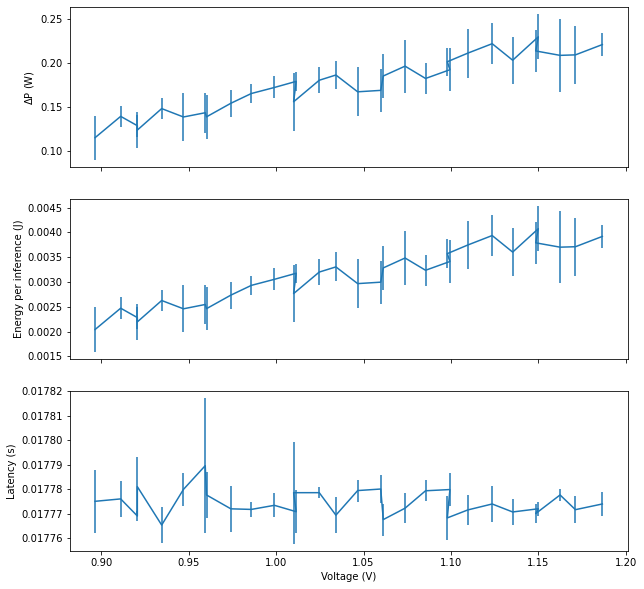

In [69]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(10,10))

axs[0].errorbar(v_real, delta_p_mean, yerr=delta_p_std)
axs[0].set_ylabel('$\Delta$P (W)')

axs[1].errorbar(v_real, energy_mean, yerr=energy_std)
axs[1].set_ylabel('Energy per inference (J)')

axs[2].errorbar(v_real, latency_mean, yerr=latency_std)
axs[2].set_ylabel('Latency (s)')
axs[2].set_xlabel('Voltage (V)')

plt.savefig('v_dependency_f100.pdf')

plt.show()

## Both $V_{INT}$ and $f$

In [38]:
v_target = np.arange(1.2, 0.9, -0.03)
v_real = np.zeros_like(v_target)
f_target = np.arange(100, 0, -10)
f_real = np.zeros_like(f_target)
v_target, f_target

(array([1.2 , 1.17, 1.14, 1.11, 1.08, 1.05, 1.02, 0.99, 0.96, 0.93]),
 array([100,  90,  80,  70,  60,  50,  40,  30,  20,  10]))

In [39]:
smu = rm.open_resource(VISA_ADDR)

In [40]:
delta_p_mean = np.zeros((v_target.size, f_target.size))
delta_p_std = np.zeros((v_target.size, f_target.size))
energy_mean = np.zeros((v_target.size, f_target.size))
energy_std = np.zeros((v_target.size, f_target.size))

latency_mean = np.zeros((v_target.size, f_target.size))
latency_std = np.zeros((v_target.size, f_target.size))

for i in tqdm(range(v_target.size)):
    pmic.set_vint(v_target[i])
    v_real[i] = check_vint_xadc(xadc)
    
    for j in range(f_target.size):
        
        Clocks.fclk0_mhz = f_target[j]
        f_real[j] = Clocks.fclk0_mhz
    
        latencies = model.measure_latency(100, 10, False)
        timestamps, power = measure_power(model, 10)

        delta_p_mean[i,j], delta_p_std[i,j], energy_mean[i,j], energy_std[i,j] = mean_std_power_energy(timestamps, power, latencies)

        latency_mean[i,j] = latencies.mean()
        latency_std[i,j] = latencies.std()

        np.savez('v_f_dependency.npz', v=v_real, f=f_real, delta_p_mean=delta_p_mean, delta_p_std=delta_p_std, energy_mean=energy_mean, energy_std=energy_std, latency_mean=latency_mean, latency_std=latency_std)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 90.90909MHz.
  warnings.warn(
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 83.33333MHz.
  warnings.warn(
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 71.42857MHz.
  warnings.warn(
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 58.82353MHz.
  warnings.warn(
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 30.30303MHz.
  warnings.warn(
100%|██████████| 10/10 [2:03:09<00:00, 738.92s/it] 


In [41]:
smu.close()

In [43]:
X, Y = np.meshgrid(v_real, f_real)

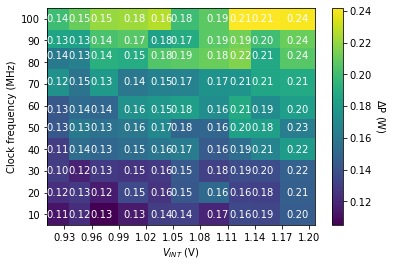

In [49]:
plt.pcolormesh(X, Y, delta_p_mean)

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('$\Delta$P (W)', rotation=270)

plt.yticks(f_target)
plt.xticks(v_target)

plt.ylabel('Clock frequency (MHz)')
plt.xlabel('$V_{INT}$ (V)')

# Annotate the Z values on the plot
for i in range(delta_p_mean.shape[0]):
    for j in range(delta_p_mean.shape[1]):
        plt.text(v_real[i], f_real[j], '%.2f' % delta_p_mean[i, j],
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white')

plt.savefig('delta_P_v_f_dependency.pdf')

## Reset to defaults

In [50]:
pmic.set_vint(1)
Clocks.fclk_0 = 100